In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from numpy.matlib import repmat
import data
import plot as pt
from matplotlib import pyplot as plt
import gaussian_process as gp

In [3]:
df = data.get_data()
df = data.excess_return_unit(df)

(array([  2.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          1.,   1.,   2.,   3.,   0.,   0.,   0.,   1.,   5.,   0.,   4.,
          2.,   4.,   7.,   3.,   3.,   5.,   6.,   8.,   5.,   8.,  11.,
         12.,   6.,  13.,  10.,  15.,  20.,  24.,  35.,  39.,  28.,  48.,
         60.,  80., 108., 123., 107.,  97.,  90.,  64.,  66.,  54.,  55.,
         34.,  39.,  32.,  22.,  27.,  18.,  24.,  10.,  12.,   8.,   6.,
          5.,   2.,   6.,   2.,   3.,   1.,   2.,   1.,   3.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.04396366, -0.04304403, -0.04212439, -0.04120476, -0.04028512,
        -0.03936549, -0.03844585, -0.03752622, -0.03660659, -0.03568695,
        -0.03476732, -0.03384768, -0.03292805, -0.03200841, -0.03108878,
        -0.03016914, -0.02924951, -0.02832988, -0.02741024, -0.02649061,
        -0.02557097, -0.02

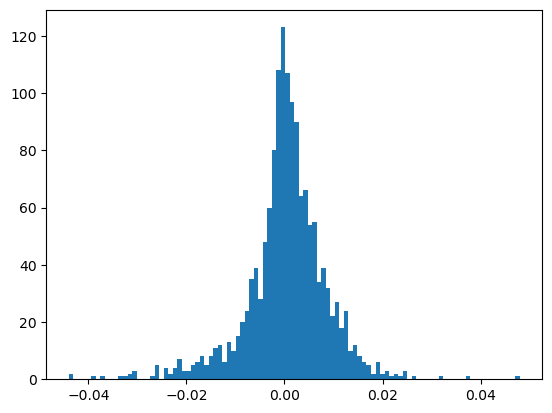

In [4]:
plt.hist(df['Excess Return'], bins=100)

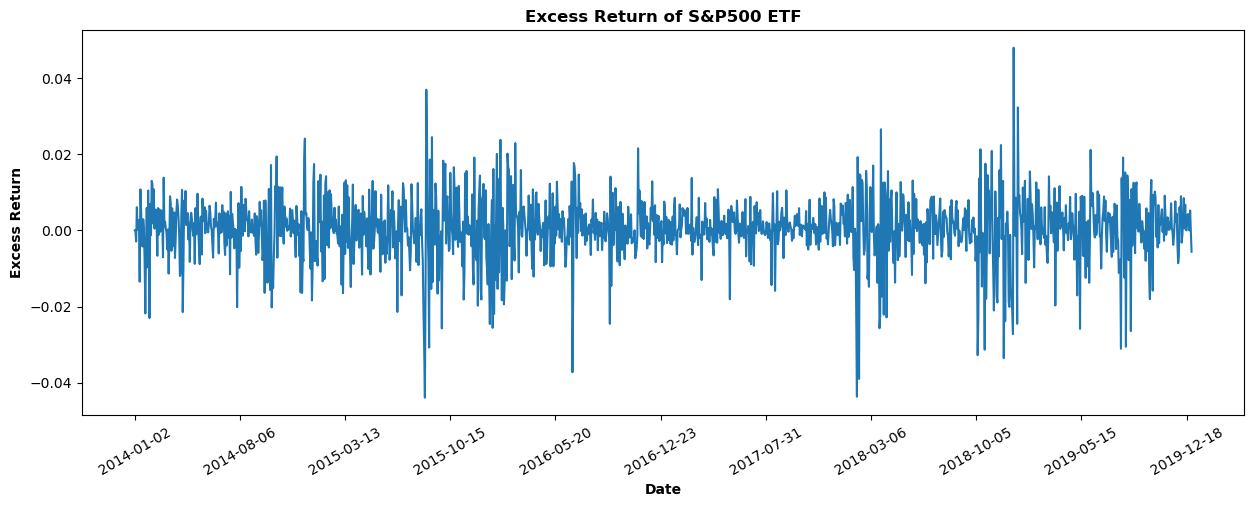

In [3]:
pt.plot_excess_return(df)

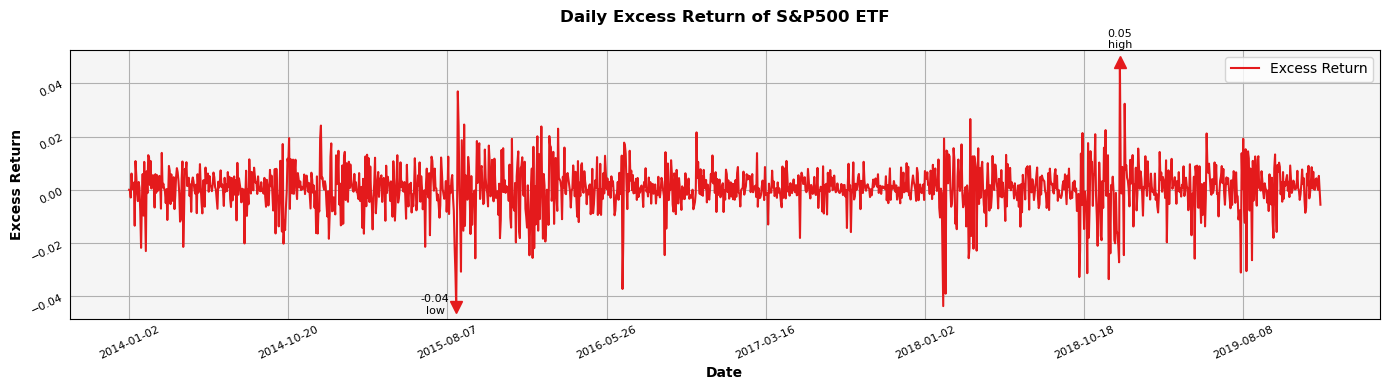

In [4]:
pt.plot_time_series_annotated(df=df, ylabel='Excess Return',x_col='Date', y_cols=['Excess Return'], title='Daily Excess Return of S&P500 ETF')

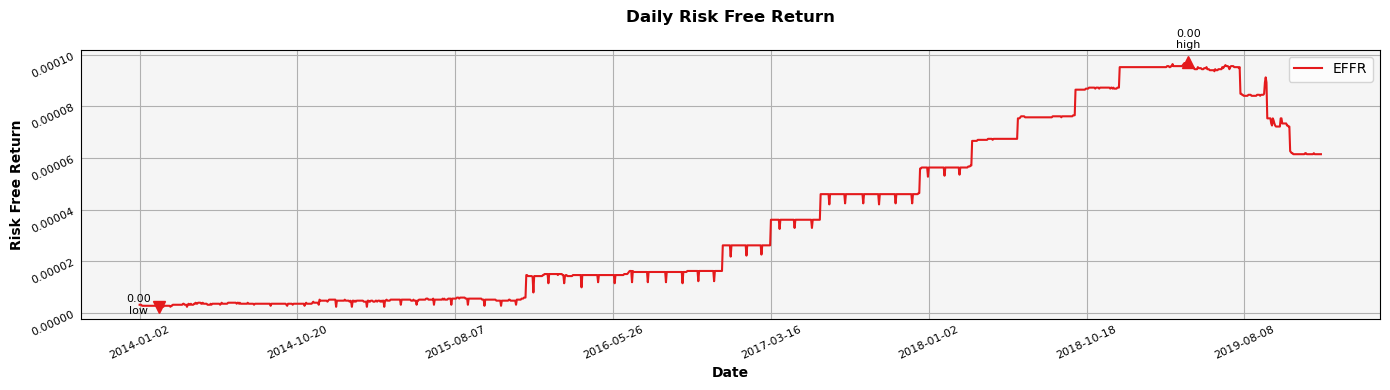

In [5]:
pt.plot_time_series_annotated(df=df, ylabel='Risk Free Return', x_col='Date', y_cols=['EFFR'], title='Daily Risk Free Return')

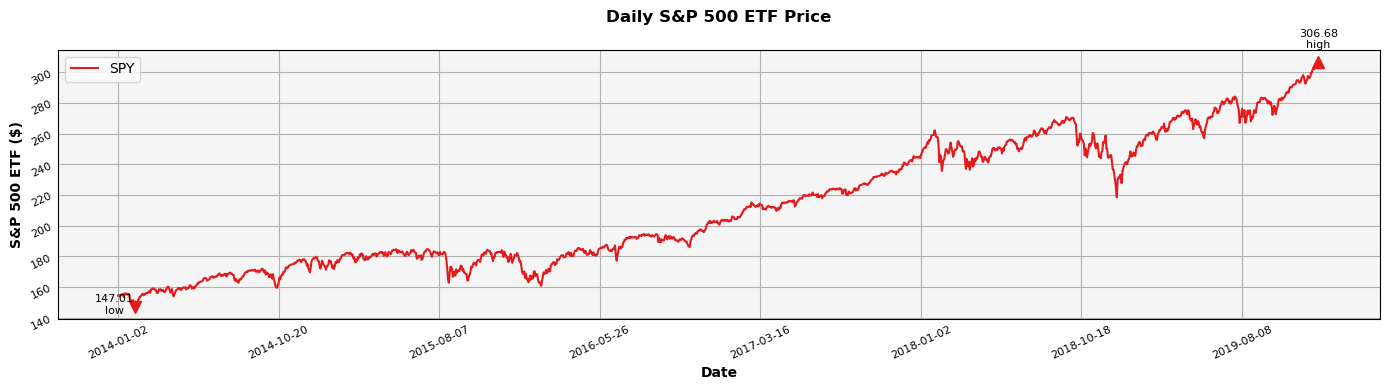

In [6]:
pt.plot_time_series_annotated(df=df, ylabel='S&P 500 ETF ($)', x_col='Date', y_cols=['SPY'], title='Daily S&P 500 ETF Price')

In [7]:
df = data.moving_averages(df)

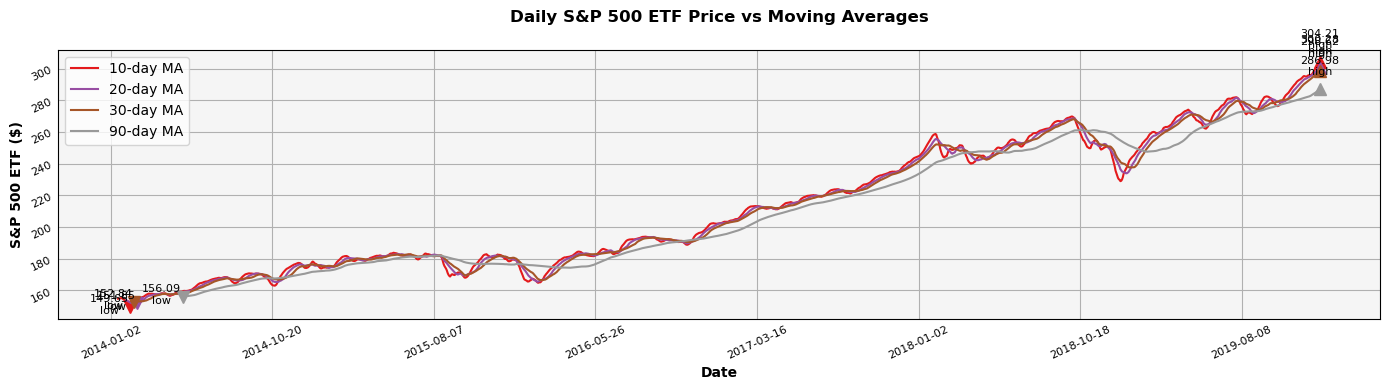

In [8]:
pt.plot_time_series_annotated(df=df, ylabel='S&P 500 ETF ($)', x_col='Date', y_cols=['10-day MA', '20-day MA', '30-day MA', '90-day MA'], title='Daily S&P 500 ETF Price vs Moving Averages')

In [9]:
df = data.exponential_moving_averages(df)

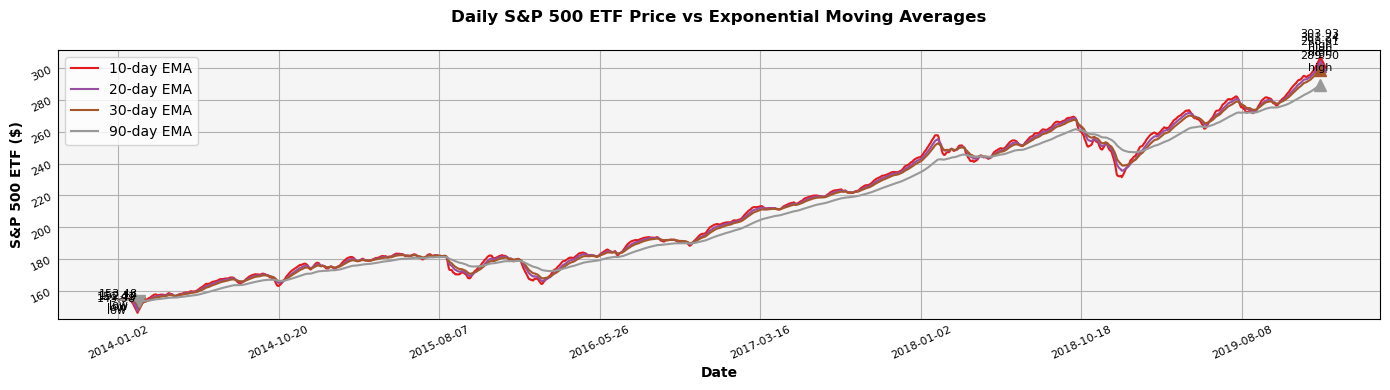

In [10]:
pt.plot_time_series_annotated(df=df, ylabel='S&P 500 ETF ($)', x_col='Date', y_cols=['10-day EMA', '20-day EMA', '30-day EMA', '90-day EMA'], title='Daily S&P 500 ETF Price vs Exponential Moving Averages')

In [3]:
gaussian_process = gp.GaussianProcess(df)

In [ ]:
X = df[['SPY', 'Excess Return', 'EFFR']].values

In [ ]:
f = gaussian_process.sample_prior(X=X, Z=X, mu=df['SPY'].values, sigma=1, l=1, ktype='matern', n_samples=20)

In [ ]:
pt.plot_sampled_functions(df=df, f=f, title='Sampled Functions')

In [4]:
n_train = int(len(df) * 0.7)

In [ ]:
f_posterior = gaussian_process.gp_posterior(X_old=X[:n_train], X_new=X[n_train:], mu_old=df['SPY'].values[:n_train], mu_new=df['SPY'].values[n_train:], n_samples=20, sigma=1, l=1, ktype='matern')

In [ ]:
pt.plot_distribution(np.arange(f_posterior.shape[-1]).reshape(-1,1), f_posterior)

In [ ]:
df_posterior = df[-len(f[-1]):].copy()
df_posterior['GP'] = np.mean(f, axis=0)

In [ ]:
pt.plot_time_series_annotated(df=df_posterior, ylabel='Price ($)', x_col='Date', y_cols=['SPY', 'GP'], title='S&P500 vs. Gaussian Process', figsize=(15, 5))

In [ ]:
X = df[['SPY', 'Excess Return', 'EFFR']].values

In [ ]:
f = gaussian_process.sample_prior(X=X, Z=X, mu=df['SPY'].values, sigma=1, l=1, ktype='matern', n_samples=10)

In [ ]:
df_posterior = df[-len(f[-1]):].copy()
df_posterior['GP'] = np.mean(f, axis=0)

In [ ]:
df.head()

In [ ]:
# use fit to predict with GPs

In [ ]:

error_sign = np.sign(df['GP Error'].values)
positive_inteval_errors = np.where(error_sign == 1)[0]
negative_inteval_errors = np.where(error_sign == -1)[0]

print(f'Number of positive errors: {np.sum(error_sign == 1)}')
print(f'Number of negative errors: {np.sum(error_sign == -1)}')

# get length of consecutive positive and negative errors
positive_intervals = np.split(positive_inteval_errors, np.where(np.diff(positive_inteval_errors) != 1)[0]+1)
negative_intervals = np.split(negative_inteval_errors, np.where(np.diff(negative_inteval_errors) != 1)[0]+1)

print(f'Longest positive error interval: {np.max([len(interval) for interval in positive_intervals])}')
print(f'Longest negative error interval: {np.max([len(interval) for interval in negative_intervals])}')

print(f'mean length of positive error interval: {np.mean([len(interval) for interval in positive_intervals])}')
print(f'mean length of negative error interval: {np.mean([len(interval) for interval in negative_intervals])}')


In [ ]:
def gp_trading_strategy(df, start_val=2*(10**5), leverage=5, trade_cost=0.005):
    """
    Trading strategy based on the GP predictions.
    If the GP prediction is higher than the actual value, we buy.
    If the GP prediction is lower than the actual value, we sell.
    We buy/sell with leverage and trade costs.

    Args:
        df (pd.DataFrame): dataframe with data
    
    Returns:
        df (pd.DataFrame): dataframe with predictions
    """
    df_new = df.copy()
    # start trading
    df_new['GP Position'] = 0
    df_new['GP Position'].iloc[0] = start_val
    df_new['Benchmark Position'] = 0
    df_new['Benchmark Position'].iloc[0] = start_val

    # buy all stocks at the beginning for benchmark
    df_new['Benchmark Position'].iloc[1] = df_new['Benchmark Position'].iloc[0] - leverage * df_new['SPY'].iloc[1] * (1 + trade_cost)

    for i in range(1, len(df_new)):
        # benchmark update by holding SPY from column 'Excess Return'
        df_new['Benchmark Position'].iloc[i] = df_new['Benchmark Position'].iloc[i-1] + df_new['Excess Return'].iloc[i] * df_new['Benchmark Position'].iloc[i-1] 
        
        if df_new['GP'].iloc[i] < df_new['SPY'].iloc[i-10]: # change to i possibly
            # buy
            df_new['GP Position'].iloc[i] = df_new['GP Position'].iloc[i-1] - leverage * df_new['SPY'].iloc[i] * (1 + trade_cost)
        else:
            # sell
            df_new['GP Position'].iloc[i] = df_new['GP Position'].iloc[i-1] + leverage * df_new['SPY'].iloc[i] * (1 - trade_cost)
        
    return df_new
    

In [ ]:
df_test = gp_trading_strategy(df)

In [ ]:
df_test.head()

In [ ]:
plt.plot(df_test['GP Position'].values, label='GP Position')
plt.plot(df_test['Benchmark Position'].values, label='Buy and Hold')
plt.legend();

In [ ]:
plt.plot(np.arange(n_train), df['SPY'][:n_train].values, label='SPY train')
plt.plot(np.arange(n_train, len(df)), df['SPY'][n_train:].values, label='SPY test')
plt.legend();

In [5]:
X = df[['Excess Return', 'EFFR']].values 

In [18]:
f = gaussian_process.sample_prior(X=X, Z=X, mu=df['Excess Return'].values, sigma=1, l=1, ktype='matern', n_samples=10)

/Users/eirikbaekkelund/Desktop/UCL/Code/FinanceTradingApps/project_alg_trading/gaussian_process.py:64: RuntimeWarning: covariance is not positive-semidefinite.
  f = np.random.multivariate_normal(mu, K, size=n_samples)


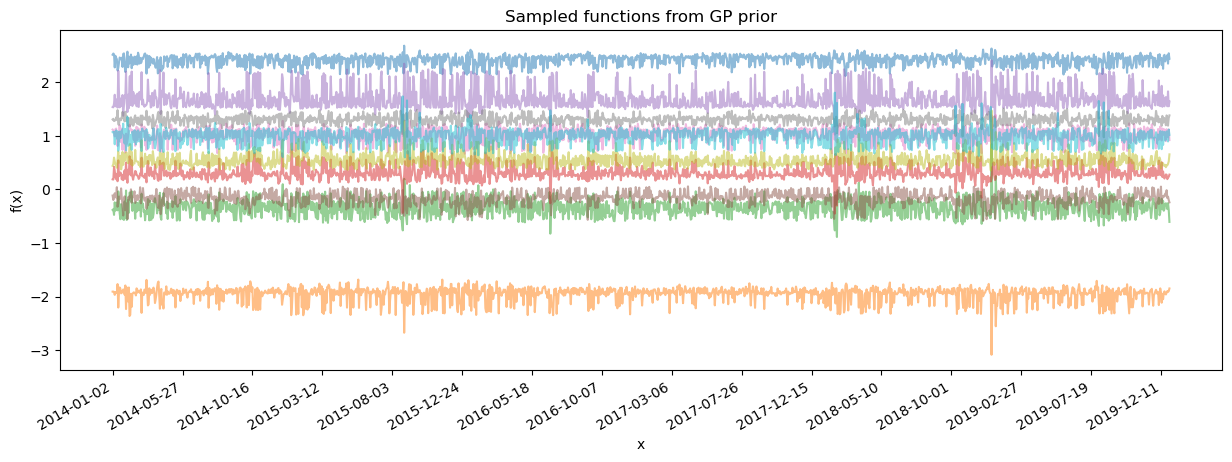

In [19]:
pt.plot_sampled_functions(df=df, f=f, title='Sampled functions from GP prior')

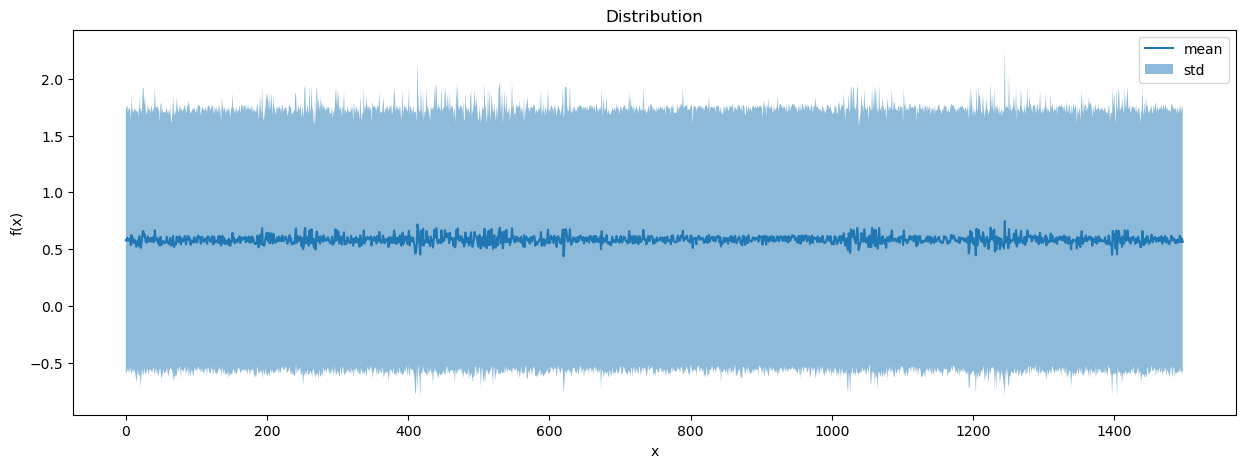

In [20]:
pt.plot_distribution(np.arange(f.shape[-1]).reshape(-1,1), f)

In [13]:
n_train = int(len(df) * 0.7)

In [14]:
f_posterior = gaussian_process.gp_posterior(X_old=X[:n_train], X_new=X[n_train:], mu_old=df['Excess Return'].values[:n_train],mu_new=df['Excess Return'].values[n_train:], sigma=0.001, l=100, ktype='matern', n_samples=100)

/Users/eirikbaekkelund/Desktop/UCL/Code/FinanceTradingApps/project_alg_trading/gaussian_process.py:97: RuntimeWarning: covariance is not positive-semidefinite.
  f_old = np.mean( np.random.multivariate_normal(mu_old, k_11, size=n_samples), axis=0)
/Users/eirikbaekkelund/Desktop/UCL/Code/FinanceTradingApps/project_alg_trading/gaussian_process.py:102: RuntimeWarning: covariance is not positive-semidefinite.
  f = np.random.multivariate_normal(mu_conditional, k_conditional, size=n_samples)


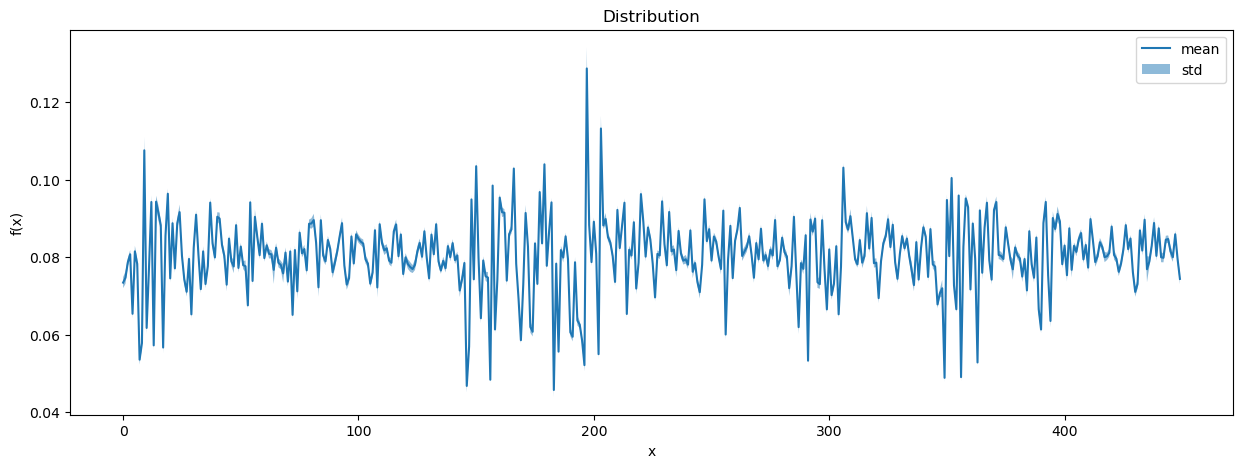

In [15]:
pt.plot_distribution(np.arange(f_posterior.shape[-1]).reshape(-1,1), f_posterior)

In [16]:
df_posterior = df[-len(f_posterior[-1]):].copy()
df_posterior['GP'] = np.mean(f_posterior, axis=0) - np.mean(f_posterior)

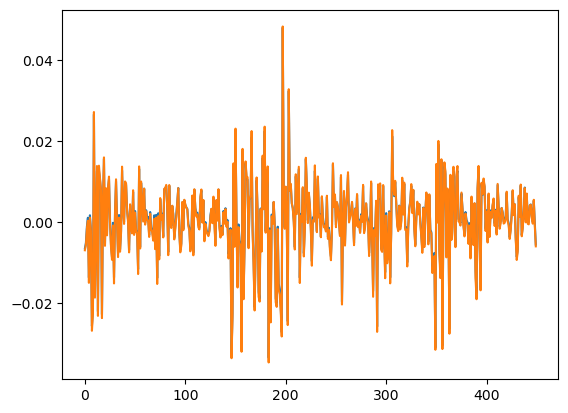

In [17]:
plt.plot(df_posterior['Excess Return'].values, label='Excess Return')
plt.plot(df_posterior['GP'].values, label='GP')

In [18]:
# check if the next value is higher or lower than the past value
gp_diff = np.array([1 if df_posterior['GP'].iloc[i] > df_posterior['GP'].iloc[i-1] else -1 for i in range(1, len(df_posterior))])
return_diff = np.array([1 if df_posterior['Excess Return'].iloc[i] > df_posterior['Excess Return'].iloc[i-1] else -1 for i in range(1, len(df_posterior))])

# check if the prediction was correct
correct = np.sum(gp_diff == return_diff)

# proportion correct
correct / len(gp_diff)

1.0

In [ ]:
df_test1 = gaussian_process.fit(col='Excess Return', n_samples=10)